# Cálculo del Centro de Masa de la Densidad de Fuentes de Corriente en Paralelo

En este *notebook* de Julia implementaremos métodos numéricos para llevar a cabo un análisis de *centro de masa* (promedio vectorial) de la densidad de pozos y fuentes de corriente sobre una rebanada del hipocámpo de una rata. En este Notebook estudiaremos los datos de los experimentos evocados que hizo Franco en Agosto.

Hay un par de cosas a considerar previamente. La forma en que los datos están guardados en el archivo de BrainWave es un HDF5 de altá densidad, y cada dato está codificado como un entero Uint16 pero con sólo 12 bits de *profundidad*. Es más bien un Uint12 escrito como un Uint16. 

In [2]:
using HDF5 #Leer datos en HDF5 

In [3]:
DatosPrueba=h5open("../050815_1R4.brw", "r")

HDF5 data file: ../050815_1R4.brw

Los archivos tienen una estructura rica dividida en pseudo directorios. Para enumerar los directorios podemos hacer lo siguiente ( o podemos consultar la documenteción, pero es bueno ver que hay adentro por nuestros propios medios).

In [4]:
for a in DatosPrueba
    println(a)
end

HDF5 group: /3BData (file: ../050815_1R4.brw)
HDF5 group: /3BRecInfo (file: ../050815_1R4.brw)
HDF5 group: /3BUserInfo (file: ../050815_1R4.brw)


Julia interpreta esto como un dixcionario. Cada uno de los términos es una *clave* que tiene dentro aún más estructura.
Leyendo la documentación vemos que en `/3BData` hay otra clave que se llama `Raw` y ahí están los datos. En `/3BRecInfo` están los parámetros de las medida experimentales, como voltaje máximo y esas cosas. Eventualmente las necesitaremos para plotear en Volts, aunque es probable que eso de momento no sea necesario. Lo que si nos interesa es el número de cuadros y la frecuencia de muestreo, para saber la longitud del experimento.

In [5]:
for a in DatosPrueba["/3BRecInfo/3BRecVars"]
    println(a)
end

HDF5 dataset: /3BRecInfo/3BRecVars/BitDepth (file: ../050815_1R4.brw)
HDF5 dataset: /3BRecInfo/3BRecVars/MaxVolt (file: ../050815_1R4.brw)
HDF5 dataset: /3BRecInfo/3BRecVars/MinVolt (file: ../050815_1R4.brw)
HDF5 dataset: /3BRecInfo/3BRecVars/NRecFrames (file: ../050815_1R4.brw)
HDF5 dataset: /3BRecInfo/3BRecVars/SamplingRate (file: ../050815_1R4.brw)
HDF5 dataset: /3BRecInfo/3BRecVars/SignalInversion (file: ../050815_1R4.brw)


In [6]:
#Por alguna estúpida razón, son arrays de arrays...
numerocuadros=DatosPrueba["/3BRecInfo/3BRecVars/NRecFrames"][1][1]
frecuencia=DatosPrueba["/3BRecInfo/3BRecVars/SamplingRate"][1][1]
maxvolt=DatosPrueba["/3BRecInfo/3BRecVars/MaxVolt"][1][1]
minvolt=DatosPrueba["/3BRecInfo/3BRecVars/MinVolt"][1][1]
bitdepth=DatosPrueba["/3BRecInfo/3BRecVars/BitDepth"][1][1]
(numerocuadros, frecuencia)

(210624,7020.800706028248)

In [7]:
duracionexperimento=numerocuadros/frecuencia

29.99999698312937

In [8]:
factordeescala=(maxvolt-minvolt)/2^bitdepth

2.01416015625

In [9]:
300/factordeescala

148.94545454545454

Franco llevó a cabo tres estimulos durante el experimento. Como tienen una separación de exactamente 10 segundos, el primero debe de estar en los primeros 10 segundos, es decir, en los primeros 70208 cuadros.

In [10]:
DatosCrudos=read(DatosPrueba["/3BData/Raw"]);
diezsegundos=70208 #aprox 

70208

Parece que Julia no es taaaaan lista para ordenar los datos con un simple reshape. Asi que toca hacerlo a manitou.
(Nota: no, al parecer si lo hace bien, y  le toma aprox el mismo tiempi)

In [11]:
aux=Array(Int32, 64,64,210624);
for j=1:64,k=1:64
    aux[k,j,:]=DatosCrudos[j+(k-1)*64,:]
end
DatosCentrados=int32(aux)*(-1)+2048;
aux=0

0

In [12]:
extrema(DatosCentrados)
findmin(DatosCentrados)
#1750/factordeescala

(-2009,468976556)

Vamos a trabajar en enteros con signo. Vamos a respetar la escala que ya viene grabada y simplemente le vamos a poner el cero en donde va. Los datos estan "de cabeza" y desplazados a la mitad de la escala, que es de `2^bitdepth`. Entonces lo que hay que hacer es multiplicarlos por $(-1)$ y sumarles 2048.

## Sección 1: Obtención de la densidad de fuentes de corriente (CSD)

Una convolución con una Gaussiana de ancho adecuado es equivalente a un filtro pasabajos diferenciable. Implementaremos la convolución de forma que podamos eliminar el ruido de altas frecuencias intrínseco del aparato de medición (BioCAM4096).

In [13]:
OperadorLaplacianoGordo=int32([[1 4 1],[4 -20 4],[1 4 1]])

3x3 Array{Int32,2}:
 1    4  1
 4  -20  4
 1    4  1

In [14]:
function Int32Laplacian(Datos)
    result=zeros(Datos)
    temp=copy(Datos)
    #Primero, hacemos el padding de los datos para que no se suavice demasiado
    temp=vcat(temp[1,:], temp, temp[end,:])
    temp=hcat(temp[:,1], temp, temp[:,end])
    largo,ancho=size(Datos)
    aux=Array(Float32,(3,3))
    result=zeros(Datos)
    for j=2:largo+1, k=2:ancho+1
        #los indices van primero, "renglones", luego "columnas", etc
        aux=temp[j-1:j+1,k-1:k+1]
        result[j-1,k-1]=sum(OperadorLaplacianoGordo.*aux)
    end
    return result
end


Int32Laplacian (generic function with 1 method)

In [15]:
#Ejemplo a comparar
Ejemplo=DatosCentrados[:,:,11180];

In [16]:
using PyPlot

INFO: Loading help data...


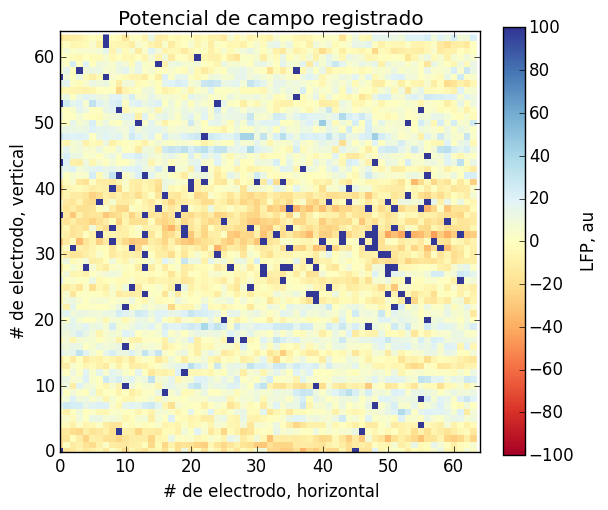

PyObject <matplotlib.text.Text object at 0x7fbc8d897198>

In [17]:
PyPlot.ion()
figure(figsize=(6,6))
title("Potencial de campo registrado")
limites=100
PyPlot.xlim(0,64)
PyPlot.ylim(0,64)
imagen=imshow(Ejemplo, cmap="RdYlBu", interpolation="none", origin="lower", vmin=-1*limites,vmax=limites)
cbx=colorbar(imagen, fraction=0.046) 
cbx[:set_label]("LFP, au")
xlabel("# de electrodo, horizontal")
ylabel("# de electrodo, vertical")

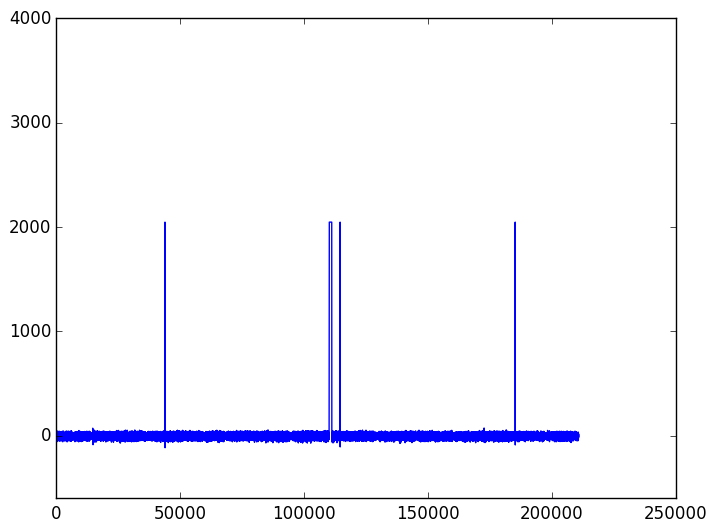

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fbbf498e080>

In [18]:
ion()
rango=1:numerocuadros
rango2=rango+diezsegundos
ylim(-600,4000)
plot(rango, vec(DatosCentrados[40,50,:]))
#plot(rango,vec(DatosCentrados[40,44,rango2]))

In [19]:
function EncuentraTrancazos(datos::Array, tolerancia=700)
    result=Int[]
    longitud=length(datos)
    jcomp=0
    for j=1:longitud
        if abs(datos[j])>tolerancia
            if j-jcomp>1
                push!(result,j)
            end
            jcomp=j
        end
    end
    return result
end



EncuentraTrancazos (generic function with 2 methods)

In [20]:
ListaTrancazos=EncuentraTrancazos(vec(DatosCentrados[20,24,:]), 1000)

4-element Array{Int64,1}:
  43889
  94193
 114497
 185105

In [21]:
ActividadAlrededorTrancazos=Dict{String, Array}()
q=1
desde=20
hasta=280
for j in ListaTrancazos
    nomineclave="Trancazo_$q"
    ActividadAlrededorTrancazos[nomineclave]=DatosCentrados[:,:,j-desde:j+hasta]
    println(nomineclave)
    q+=1
end

Trancazo_1
Trancazo_2
Trancazo_3
Trancazo_4


In [34]:
size(ActividadAlrededorTrancazos["Trancazo_3"])

(64,64,301)

Hay un montonal de canales que por la forma en que requiere ser hecho el experimento no detectaron nada o casi nada. Esos aparecen el registro como saturados en el máximo valor posible. Dado que esto es MUY inconveniente para el cálculo del CM, tenemos que detectarlos automáticamente y ponerlos en cero o ver si los esquivamos.

In [22]:
function BuscaSaturados(datos::Array, saturavalue=1700)
    (ancho,alto,largo)=size(datos)
    result=Set{Array{Int,1}}()
    arreglostd=zeros(ancho,alto)
    arregloprom=zeros(ancho,alto)
    for j=1:ancho, k=1:alto
        prom=mean(datos[k,j,:])
        arregloprom[k,j]=prom
        desviacion=std(datos[k,j,:])
        arreglostd[k,j]=desviacion
        if abs(prom)>saturavalue || desviacion<10
            push!(result, [k,j])
        end
    end
    return (result,arreglostd, arregloprom)
end

BuscaSaturados (generic function with 2 methods)

In [23]:
(Saturados_1,desvia, prom)=BuscaSaturados(ActividadAlrededorTrancazos["Trancazo_1"]);
desvia[1:1]
(Saturados_2,desvia, prom)=BuscaSaturados(ActividadAlrededorTrancazos["Trancazo_2"]);
desvia[1:1]
(Saturados_3,desvia, prom)=BuscaSaturados(ActividadAlrededorTrancazos["Trancazo_3"]);
desvia[1:1]
(Saturados_4,desvia, prom)=BuscaSaturados(ActividadAlrededorTrancazos["Trancazo_4"]);
desvia[1:1]

1-element Array{Float64,1}:
 118.045

In [49]:
for l in Saturados_4
    (p,q)=l
    ActividadAlrededorTrancazos["Trancazo_4"][p,q,:]=0
end

In [132]:
for j=1:40
    print(j)
end

12345678910111213141516171819202122232425262728293031323334353637383940

In [136]:
PyPlot.ioff()
limites=100
rango=1:4

#for j=rango
 j=177   
    b=round((j-20)/7.022,4)
    titulo="$b ms"
    figure(figsize=(6,6))
PyPlot.xlim(-0.5,64)
    ylim(-0.5,64)
    Ejemplo=LFPPromedioTrancazos[:,:,j]
    imagen=imshow(Ejemplo, cmap="jet", interpolation="none", origin="lower", vmin=-1*limites,vmax=limites)
    cbx=colorbar(imagen, fraction=0.046) 
    title(titulo)
    savefig("LFPEvocado_1R4-Promedio-$j.png", dpi=90)
    close()
#end

In [50]:
LFPPromedioTrancazos=zeros(ActividadAlrededorTrancazos["Trancazo_1"])
for t=1:301
    LFPPromedioTrancazos[:,:,t]=(ActividadAlrededorTrancazos["Trancazo_1"][:,:,t]+
    ActividadAlrededorTrancazos["Trancazo_2"][:,:,t]
    +ActividadAlrededorTrancazos["Trancazo_3"][:,:,t]
    +ActividadAlrededorTrancazos["Trancazo_4"][:,:,t])
end

64x64 Array{Int32,2}:
   0   13   43   22   17   40   17   39  …   44   40   67    6   46   27   43
  36    1   46   32   48   43   21   43      24   27   21   26   16   48   43
  62   53   52   20   44   42   73   47      53   49   69   52   43   50   32
  17    9    0    6   30   10   21   24      47   29   18   36   45   38   13
  15    1   -1    1   20   29    9   15      63   38   46   35   44   29   38
  39   47   22   46   48   13   36   30  …   19   31   27   35   16   25    2
  32   49   27   13   45   29   40   -3      41   40   82   69   49   52   66
  31   40   44   35   47   23   20   10      44   43   74   42   43   45   22
  41   31   15   13   38   31   48   12      56   43   46   43   62   62   54
  25    4   17   28   -2    0   -3   13      52   13   43   42   23   21   55
  35   63   79   24   38   66   42   67  …   71   56   32   26   34   30   57
  43   25   35   53   35   49   46   41      82   55   64   77   58   91   74
  47   41   42   57   51   26   31   50   

In [24]:
function UnNormGauss(x,sigma)
    return exp(-x*x/(2*sigma))
end

function GaussSuavizar(Datos,Sigma)  
    #sigma esta medido en pixeles, es la desviacion estandar de nuestro kernel.
    #El medioancho de nuestra ventana seran 3*sigma
    medioancho=ceil(Sigma*3)
    colchon=ones(medioancho)
    result=zeros(Datos)
    datoscolchon=vcat(colchon*Datos[1], Datos, colchon*Datos[end])
    kernel=map(x->UnNormGauss(x,Sigma), [-medioancho:medioancho])
    kernel=kernel/(sum(kernel))
    #La convolucion asi normalizada preserva el valor RELATIVO entre los puntos de la funcion.
    #pero queremos ponerlo mas parecido a los voltajes que medimos, para preservar el rango de valores
    #experimentales y su criterio de potenciales de accion / ruido
    for t=medioancho+1:length(Datos)-medioancho
        result[t-medioancho]=sum(datoscolchon[t-medioancho:t+medioancho].*kernel)
    end
    a=maximum(abs(Datos))
    b=maximum(abs(result))
    #nromalizacion 
    #result=result*a/b
    return result
end
    

GaussSuavizar (generic function with 1 method)

Ahora, dado que el operador Laplaciano numérico es *extremadamente* sensible a los bordes, es necesario suavizar éstos. Dicho de otra forma, tenemos que eliminar el ruido espacial proveniente de la geometría y resolución del aparato. De forma similar a lo llevado a cabo anteriormente, haremos una convolución con una Gaussiana del 3 y medio píxeles de ancho (*Gaussian blur*).

In [25]:
GaussianKernel=readdlm("GaussianMatrix.dat")

7x7 Array{Float64,2}:
 6.7e-7      2.292e-5    0.00019117  …  0.00019117  2.292e-5    6.7e-7    
 2.292e-5    0.00078634  0.00655965     0.00655965  0.00078633  2.292e-5  
 0.00019117  0.00655965  0.0547216      0.0547216   0.00655965  0.00019117
 0.00038771  0.0133037   0.110982       0.110982    0.0133037   0.00038771
 0.00019117  0.00655965  0.0547216      0.0547216   0.00655965  0.00019117
 2.292e-5    0.00078633  0.00655965  …  0.00655965  0.00078633  2.292e-5  
 6.7e-7      2.292e-5    0.00019117     0.00019117  2.292e-5    6.7e-7    

In [26]:
function GaussianSmooth(Datos)
    tamanodatos=size(Datos)
    result=zeros(Datos)
    temp=copy(Datos)
    #Primero, hacemos el padding de los datos para que no se suavice demasiado
    for j=1:3
        temp=vcat(temp[1,:], temp, temp[end,:])
    end
    for j=1:3
        temp=hcat(temp[:,1], temp, temp[:,1])
    end
    
    for j=4:tamanodatos[1]+3, k=4:tamanodatos[2]+3
        #los indices van primero, "renglones", luego "columnas", etc
        aux=temp[j-3:j+3,k-3:k+3]
        result[j-3,k-3]=sum(GaussianKernel.*aux)
    end
    #Esta convolución no respeta norma L2
    #result=result*maximum(abs(Datos))/maximum(abs(result))
    return result
end

GaussianSmooth (generic function with 1 method)

In [27]:
LFPGaussPlanchado=Dict{String, Array}()
for k in keys(ActividadAlrededorTrancazos)
    println(k)
    aux=zeros(64,64,301)
    for t=1:301
        aux2=float(ActividadAlrededorTrancazos[k][:,:,t]) 
        aux[:,:,t]=GaussianSmooth(aux2)
    end
    LFPGaussPlanchado[k]=aux
end

Trancazo_2
Trancazo_1
Trancazo_3
Trancazo_4


In [28]:
LFPPromedioPlanchado=(LFPGaussPlanchado["Trancazo_1"]+
LFPGaussPlanchado["Trancazo_3"]+LFPGaussPlanchado["Trancazo_4"]+
LFPGaussPlanchado["Trancazo_4"]);

In [80]:
PyPlot.ioff()
limites=300
rango=1:301
for j=rango
    b=round((j-20)/7.022,4)
    titulo="$b ms"
    figure(figsize=(6,6))
    xlim(-0.5,64)
    ylim(-0.5,64)
    Ejemplo=LFPPromedioPlanchado[:,:,j]
    imagen=imshow(Ejemplo, cmap="RdBu", interpolation="none", origin="lower", vmin=-1*limites,vmax=limites)
    cbx=colorbar(imagen, fraction=0.046) 
    title(titulo)
    savefig("LFPEvocado_1R4-PromedioPlanchado-$j.png", dpi=90)
    close()
end


Procedemos ahora a implementar un operador Laplaciano discreto. La forma que se aproxima más al caso ideal invariante ante rotaciones es la propuesta por T. Lindberg (1990, 1994). Esto evita efectos de "cruz" debidos a la estructura del arreglo de microelectrodos.

In [29]:
#checa que Julia va ordenando los datos renglon por renglon, no columna por columna
LaplacianTerm1=[[0 1 0], [1 -4 1], [0 1 0]]
LaplacianTerm2=[[0.5 0 0.5], [0 -2 0], [0.5 0 0.5]]
LaplacianKernel=(1-1/3)*LaplacianTerm1+(1/3)*LaplacianTerm2

function DiscreteLaplacian(Datos)
    result=zeros(Datos)
    temp=copy(Datos)
    #Primero, hacemos el padding de los datos para que no se suavice demasiado
    temp=vcat(temp[1,:], temp, temp[end,:])
    temp=hcat(temp[:,1], temp, temp[:,end])
    largo,ancho=size(Datos)
    aux=Array(Float64,(3,3))
    result=zeros(Datos)
    for j=2:largo+1, k=2:ancho+1
        #los indices van primero, "renglones", luego "columnas", etc
        aux=temp[j-1:j+1,k-1:k+1]
        result[j-1,k-1]=sum(LaplacianKernel.*aux)
    end
    return result
end

DiscreteLaplacian (generic function with 1 method)

Ahora usaremos la aproximación ohmica, homogénea e isotrópica, donde la densidad de fuentes de corriente es proporcional a el Laplaciano del potencial de campo local,
$$I_m \propto -\nabla^2 \phi$$

In [30]:
CSD=Dict{String, Array}()
for k in keys(LFPGaussPlanchado)
    println(k)
    aux=zeros(64,64,101)
    for t=1:101
        aux2=float(LFPGaussPlanchado[k][:,:,t]) 
        aux[:,:,t]=DiscreteLaplacian(aux2)
    end
    CSD[k]=aux
end

Trancazo_2
Trancazo_1
Trancazo_3
Trancazo_4


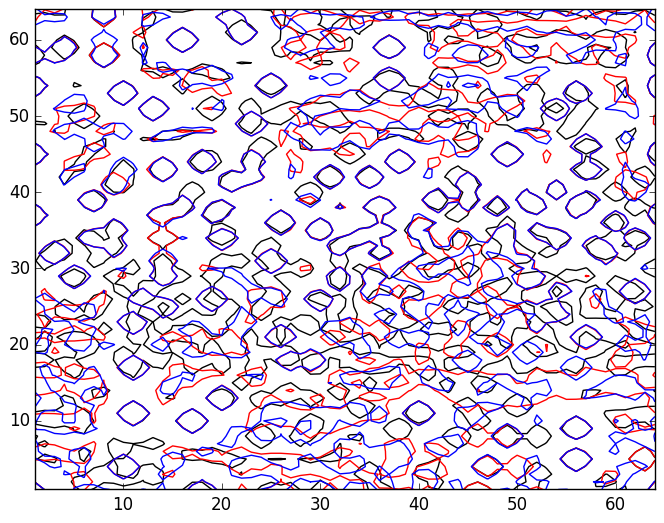

PyObject <matplotlib.contour.QuadContourSet object at 0x7fbbefeafe48>

In [68]:
niveles=[0]
Ejemplo1=CSD["Trancazo_1"][:,:,25]
Ejemplo3=CSD["Trancazo_3"][:,:,25]
Ejemplo4=CSD["Trancazo_4"][:,:,25]

contour(1:64,1:64,Ejemplo1, niveles,colors="black")
contour(1:64,1:64,Ejemplo3, niveles,colors="r", lines="--")
contour(1:64,1:64,Ejemplo4, niveles, colors="b")


### PyPlot.ioff()
limites=60
rango=61:301
for j=rango
    b=round((j-20)/7.022,4)
    titulo="$b ms"
    figure(figsize=(6,6))
    xlim(-0.5,64)
    ylim(-0.5,64)
    Ejemplo=CSDProm[:,:,j]
    imagen=imshow(Ejemplo, cmap="coolwarm", origin="lower", vmin=-1*limites,vmax=limites)
    cbx=colorbar(imagen, fraction=0.046) 
    title(titulo)
    savefig("CSDEvocado-Promedio-$j.png", dpi=90)
    close()
end


In [92]:
CSDProm=(CSD["Trancazo_1"]+CSD["Trancazo_2"]+CSD["Trancazo_3"]+CSD["Trancazo_4"]);

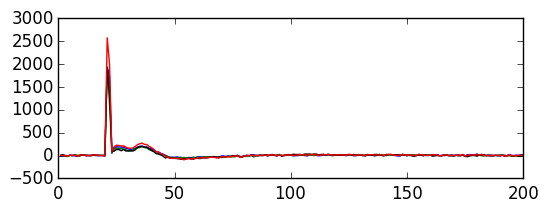

In [126]:
PyPlot.ion()
rango=1:301
(p,q)=40,50

figure(figsize=(6,2))
PyPlot.xlim(0,200)
ejemplo1=vec(LFPGaussPlanchado["Trancazo_1"][p,q,rango])
ejemplo2=vec(LFPGaussPlanchado["Trancazo_2"][p,q,rango])
ejemplo3=vec(LFPGaussPlanchado["Trancazo_3"][p,q,rango])

ejemplo4=vec(LFPGaussPlanchado["Trancazo_4"][p,q,rango])
promedio=vec(LFPPromedioPlanchado[p,q,rango]/3)
plot(rango, ejemplo4, rango, ejemplo3, rango, ejemplo1,"black", rango,promedio, "r")
savefig("PotencialesEvocados01.svg")

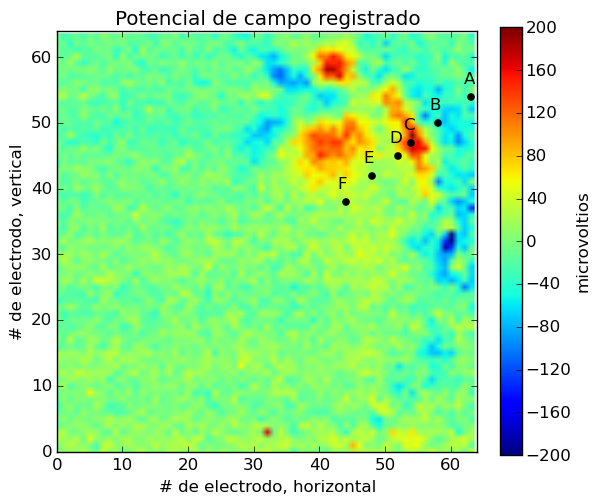

PyObject <matplotlib.text.Text object at 0x7ff336edb2e8>

In [198]:
figure(figsize=(6,6))
title("Potencial de campo registrado")
limites=100
PyPlot.xlim(0,64)
PyPlot.ylim(0,64)

imagen=imshow(Datos[:,:,599], cmap="jet", origin="lower", vmin=-2*limites,vmax=2*limites)
scatter(puntox,puntoy, marker="o", s=20, c="black")
for punto in 1:6
    annotate(puntol[punto], (puntox[punto], puntoy[punto]), xytext=(-5,10), textcoords="offset points")
end
#otraimagen=imshow(Laplaganga[:,:,1999], cmap="gist_heat", origin="lower")
cbx=colorbar(imagen, fraction=0.046) 
cbx[:set_label]("microvoltios")
xlabel("# de electrodo, horizontal")
ylabel("# de electrodo, vertical")
#savefig("LFP_jet_experimentaldataconpuntos_599.png",dpi=90)
#origin lower sigue la convención gnuplot. Origen abajo izquierda. La otra sigue la convención matrix (default).

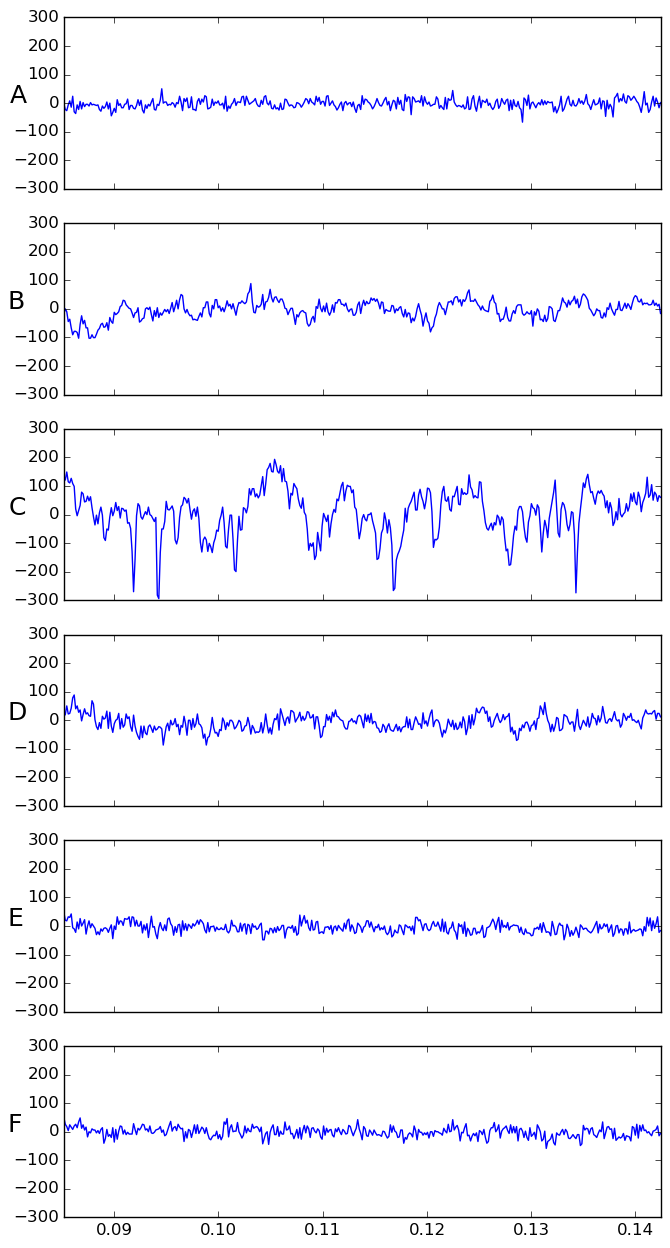

In [196]:
tiempo=598:1000
t=700

farofa, lista=subplots(6, sharex=true, sharey=true, figsize=(7.7,6*2.5))

for j=1:6
    PyPlot.xlim(598/7022,1000/7022)
    PyPlot.ylim(-300,300)
    lista[j][:plot](tiempo/7022,vec(Datos[puntoy[7-j],puntox[7-j],tiempo]))
    lista[j][:annotate](puntol[7-j],xy=(0.08,0), annotation_clip=false, fontsize=18)
end
savefig("IntentoPotencialesMedidos1.svg",dpi=90)

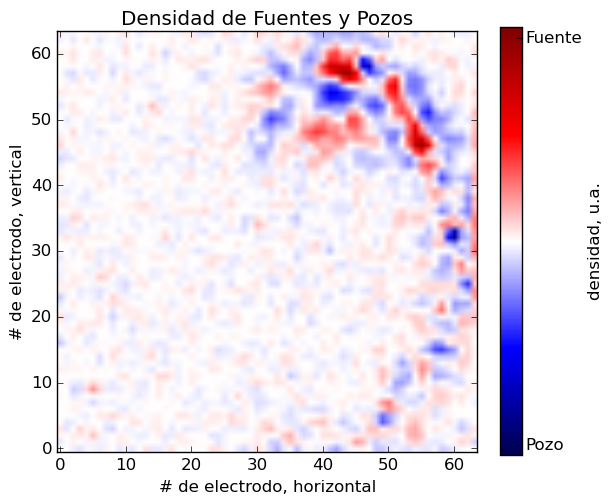

In [116]:
figure(figsize=(6,6))
#tight_layout()
title("Densidad de Fuentes y Pozos")
limites=80
#imagen=imshow(DatosLimpios[:,:,599], cmap="gist_heat", origin="lower")
otraimagen=imshow(CSDAplanado[:,:,599], cmap="seismic", origin="lower", vmin=-limites,vmax=limites)
cb=colorbar(otraimagen, fraction=0.046, ticks=[-limites*0.95, limites*0.95])
xlabel("# de electrodo, horizontal")
ylabel("# de electrodo, vertical")
cb[:set_label]("densidad, u.a.")
cb[:set_ticklabels]([{"Pozo"}, {"Fuente"}])
savefig("CSD_599.svg",dpi=90)

In [84]:
CSDAplanado[:,:,599]

64x64 Array{Real,2}:
  0         0        -2.74078  -4.39502  …  -1.02278   0         0      
 -3.3232    0         2.19949   0            6.45618   3.83577  -6.89766
  1.47622   0         2.64164   3.47259      3.07359   3.92081   2.4971 
  4.37351  -3.84213   0         7.11361     -9.26111  -4.49276   4.11362
  0        -3.83367  -2.994     0           -6.68711  -2.57213   0      
  0         0         0        -1.70576  …   0         0         0      
  0         0         2.26616   1.50477      0         0         0      
  0         0         1.51851   1.86015      3.52381   0        -2.30306
  1.18546   0        -3.79254  -2.47694      4.59666   1.36563  -1.18893
  0         0        -7.6646   -5.44506      0         3.15178   1.41112
  0         1.78667  -2.88046  -3.65521  …  -5.67534   1.86936   2.45891
  0         0         0         0           -3.43828   0         0      
  2.59407   1.28241   1.36036   1.26518      5.09244   2.95221   1.56596
  ⋮                           

In [83]:
#Quitemos los datos menores a nuestro error numérico
CSDAplanado=map(x->abs(x)<0.99? 0:x, CSD); 

In [92]:
#Guardamos los datos obtenidos, porfavor.
for t=1:tmax
    zacatlan="GarbageCollector/CSD-$t.dat"
    writedlm(zacatlan, CSDAplanado[:,:,t])
end

##Sección 2: Obtención de los componentes disjuntos.

Los pozos y fuentes tienen una separación cualitativa clara con significado físico: el signo. Esto nos permite separar la densidad de fuentes y pozos en dos conjuntos separados, claramente, el conjunto de todos los pozos y el conjunto de todas las fuentes. Si establecemos un criterio umbral mayor al error numérico, esto separa por una banda ancha los dos conjuntos, y podemos separar cada conjunto en sus *componentes disconexas"*. Esto nos permitirá trazar trayectorias de actividad coherente **justamente** sobre las estructuras fisiológicas involucradas solamente.

Primero, para poder separar las componentes disjuntas, definiremos la 8-vecindad de un electrodo como el conjunto de todos los electrodos a su alrededor inmediato:

In [16]:
function vecindad8(punto::Array)
    j=punto[1]
    k=punto[2]
    result=Set{Array{Int64,1}}()
    push!(result, [j-1,k-1])
    push!(result, [j-1,k])
    push!(result, [j-1,k+1])
    push!(result, [j,k-1])
    push!(result, [j,k+1])
    push!(result, [j+1,k-1])
    push!(result, [j+1,k])
    push!(result, [j+1,k+1])
    return result
end
    

vecindad8 (generic function with 1 method)

Procedemos ahora a separar los componentes disjuntos: si un punto es detectado como pozo o fuente dependiendo de su signo, y los vecinos inmediatos también lo son, pertenece al mismo componente, en cambio, si sus vecinos son del signo opuesto o valen cero, entonces es elemento de la frontera.

In [17]:
Pozo=Array{Int16}[]
Fuente=Array{Int16}[]
CuentaFuentes=zeros(64,64);
CuentaPozos=zeros(64,64);
#El mismo ejemplo graficado anteriormente
for j=1:64, k=1:64
    if(CSD[j,k,1999]<-0.0)      
        push!(Pozo, [j, k])
        CuentaPozos[j,k]+=1
    elseif(CSD[j,k,1999]>0.0) 
        push!(Fuente, [j, k])
        CuentaFuentes[j,k]+=1
    end             
end


Ahora implementemos el llamado pase simple para separar las componentes de cada uno de los dos conjuntos.

In [18]:
#Simple pass method
lista=copy(Fuente)
curlab=0
componentes=Set{Any}()
while(length(lista)!=0)
    x=pop!(lista) #arranca el ULTIMO elemento de la lista
    listaprofundeza=Array{Int64}[]
    componentecurlab=Array{Int64}[]
    push!(listaprofundeza, x) #Pone elementos al FINAL de la lista
    push!(componentecurlab, x)    
    profundidad=0
    while ((length(listaprofundeza)!=0) && profundidad<100)
        y=pop!(listaprofundeza)
        for v in vecindad8(y)
                if in(v, lista)
             #   println(indexin({v},lista), v)
                deleteat!(lista, indexin({v}, lista))
            #    println(v, "si estaba en la lista")
             #   println(lista)
                    push!(listaprofundeza, v)
                    profundidad+=1
                    push!(componentecurlab, v)
                else
                    #println(v, "no estaba en la lista")
                end
            end
    end
    # println("Para ", x, "la profundidad fue ", profundidad)
    curlab+=1
    push!(componentes, componentecurlab)
end
curlab

81

Para cada componente podemos obtener su "centro de masa", es decir, un promedio vectorial usando como función de peso la densidad de corriente absoluta detectada en cada punto y sus coordenadas en la matriz como vector. Simutaneamente obtendremos la *"masa"* de ese mismo componente, es decir, la densidad de corriente que  sume/surge de ese pozo/fuente en este instante de tiempo dado.

In [19]:
centrosdemasa=[[0 0 0];]
for p in componentes
    masa=0.00
    x=0.00
    y=0.00
    for q in p
        j=q[1]
        k=q[2]
        masalocal=CSD[j,k,1999]
        masa+=masalocal
        x+=k*masalocal
        y+=j*masalocal
    end
    x/=masa
    y/=masa
    A=[x y masa]
    centrosdemasa=vcat(centrosdemasa, A)
end
centrosdemasa=centrosdemasa[2:end,:];

Procedamos dibujar los *centros de masa* de los componentes disjuntos. Dibujemos un círculo centrado en el mismo *centro de masa* y con area proporcional a la *masa*, es decir a la densidad integrada sobre ese componente.

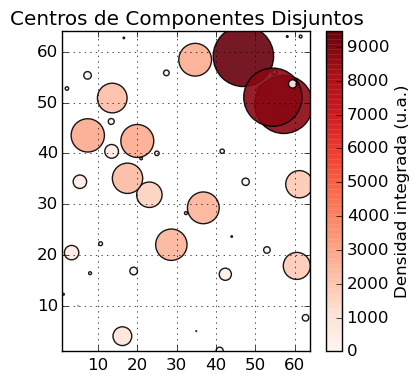

In [27]:
figure(figsize=(4,4))
title("Centros de Componentes Disjuntos")
xlim(1,64)
ylim(1,64)
imagen=scatter(centrosdemasa[:,1], centrosdemasa[:,2], 
c=centrosdemasa[:,3], s=abs(0.2*centrosdemasa[:,3]), cmap="Reds", 
alpha=0.9)
cb=colorbar(imagen)
cb[:set_label]("Densidad integrada (u.a.)")
grid()

A pesar de que hay en este ejemplo fuentes significativas fuera de CA y GD, las mayores componentes están claramente localizadas dentro del CA. Las fuentes fuera de los cuerpos neuronales deben mostrar trayectorias erráticas una vez que integremos las imagenes correspondientes en el tiempo, mientras que aquellas debidas a potenciales de acción o actividad evocada deben seguir trayectorias sobre los cuerpos neuronales involucrados. Una función auxiliar nos eliminará los "centros de masa" que sean de "masa" demasiado pequeñas.

In [20]:
function DropPeques(data)
    #solo funciona con data de dos indices.
    renglones,colus=size(data)
    prom=mean(abs(data[3]))
    result=zeros(1,colus)
    for k=1:renglones
        if abs(data[k,3])>prom
            result=vcat(result,data[k,:])
        end
    end
    return result
end

DropPeques (generic function with 1 method)

Dibujemos un ejemplo de un momento dado. El método que resuelve esto para el arreglo completo está en la última celda de código de este *notebook*.

In [29]:
t=1999
EjemploCentrosCSDPos=readdlm("GarbageCollector/CMPosLapla-$t.dat")
EjemploCentrosCSDPos=DropPeques(EjemploCentrosCSDPos)
xxpos=EjemploCentrosCSDPos[:,1]
yypos=EjemploCentrosCSDPos[:,2]
valorpos=EjemploCentrosCSDPos[:,3]
EjemploCentrosCSDNeg=readdlm("GarbageCollector/CMNegLapla-$t.dat")
EjemploCentrosCSDNeg=DropPeques(EjemploCentrosCSDNeg)
xxneg=EjemploCentrosCSDNeg[:,1]
yyneg=EjemploCentrosCSDNeg[:,2]
valorneg=EjemploCentrosCSDNeg[:,3];
CSDEjemplo=readdlm("GarbageCollector/CSD-$t.dat");

LoadError: opening file GarbageCollector/CMPosLapla-1999.dat: No such file or directory
while loading In[29], in expression starting on line 2

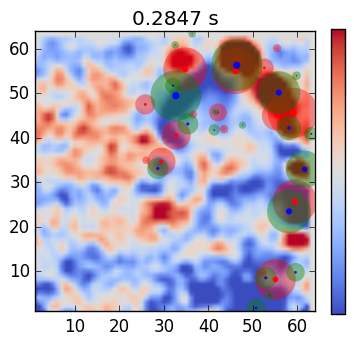

In [46]:
PyPlot.ion()
#################
seg=round(t/7022, 4)
titulo="$seg s"
figure(figsize=(4,4))
PyPlot.xlim(1,64)
PyPlot.ylim(1,64)

otraimagen=imshow(CSDEjemplo, cmap="coolwarm", origin="lower", vmin=-70, vmax=70)
cb=colorbar(otraimagen, fraction=0.046, ticks=[-150, 150])
cb[:set_ticklabels]([{"Pozo"}, {"Fuente"}])
scatter(xxpos,yypos, s=valorpos, alpha=0.4, c="r", edgecolors="none")
scatter(xxneg, yyneg, s=abs(valorneg), alpha=0.4, c="g", edgecolors="none")
scatter(xxpos,yypos, s=0.02*valorpos, alpha=0.9, c="r", edgecolors="none")
scatter(xxneg, yyneg,s=0.02*abs(valorneg), alpha=0.9, c="b", edgecolors="none")

title(titulo);

En la imágen superior los *"centros de masa"* para pozos (azul) y fuentes (rojo) están indicados con círculos pequeños, mientras que su masa integrada corresponde al área del círculo transparente alredeedor. El código de la última celda resuelve este problema secuencialmente para todos los *timeframes*. 

In [24]:
function ObtenComponentesYEscribe(Datos::Array, tini=1, tfini=tmax)

 for t=tini:tfini
    #iniciar variables vacias
    ActividadNegativa=Array{Int16}[]
    ActividadPositiva=Array{Int16}[]
    SpikeCountPositivo=zeros(64,64)
    SpikeCountNegativo=zeros(64,64)
    #Todos
    for j=1:64, k=1:64
            if(Datos[j,k,t]<-0.0)     
            push!(ActividadNegativa, [j, k])
            SpikeCountNegativo[j,k]+=1
                elseif(Datos[j,k,t]>0.0)
            push!(ActividadPositiva, [j, k])
            SpikeCountPositivo[j,k]+=1
        end             
    end

    #Simple pass method
    listaneg=copy(ActividadNegativa)
    listapos=copy(ActividadPositiva)
    componentesneg=Set{Any}()
    componentespos=Set{Any}()
    #Primero lo negativo (pozos)
    while(length(listaneg)!=0)
        x=pop!(listaneg) #arranca el ULTIMO elemento de la lista
        listaprofundeza=Array{Int64}[]
        componentecurlab=Array{Int64}[]
        push!(listaprofundeza, x) #Pone elementos al FINAL de la lista
        push!(componentecurlab, x)    
        profundidad=0
        while ((length(listaprofundeza)!=0) && profundidad<100)
            y=pop!(listaprofundeza)
            for v in vecindad8(y)
                if in(v, listaneg)
             #   
                    deleteat!(listaneg, indexin({v}, listaneg))
                    push!(listaprofundeza, v)
                    profundidad+=1
                    push!(componentecurlab, v)
                end
            end
        end
    # println("Para ", x, "la profundidad fue ", profundidad)
        
        push!(componentesneg, componentecurlab)
    end


    centrosdemasaneg=[[0 0 0];]
    for p in componentesneg
        masa=0.00
        x=0.00
        y=0.00
        for q in p
            j=q[1]
            k=q[2]
                masalocal=Datos[j,k,t]
            masa+=masalocal
            x+=k*masalocal
            y+=j*masalocal
        end
        x/=masa
        y/=masa
        A=[x y masa]
        centrosdemasaneg=vcat(centrosdemasaneg, A)
    end
    centrosdemasaneg=centrosdemasaneg[2:end,:]
    zacatlan="GarbageCollector/CMPozos-$t.dat"
    writedlm(zacatlan, centrosdemasaneg)
    ##### Ahora lo posittivo (fuentes)
    while(length(listapos)!=0)
        x=pop!(listapos) #arranca el ULTIMO elemento de la lista
        listaprofundeza=Array{Int64}[]
        componentecurlab=Array{Int64}[]
        push!(listaprofundeza, x) #Pone elementos al FINAL de la lista
        push!(componentecurlab, x)    
        profundidad=0
        while ((length(listaprofundeza)!=0) && profundidad<100)
            y=pop!(listaprofundeza)
            for v in vecindad8(y)
                if in(v, listapos)
             #   
                    deleteat!(listapos, indexin({v}, listapos))
                    push!(listaprofundeza, v)
                    profundidad+=1
                    push!(componentecurlab, v)
                end
            end
        end
    # println("Para ", x, "la profundidad fue ", profundidad)
        
        push!(componentespos, componentecurlab)
    end


    centrosdemasapos=[[0 0 0];]
    for p in componentespos
        masa=0.00
        x=0.00
        y=0.00
        for q in p
            j=q[1]
            k=q[2]
                masalocal=Datos[j,k,t]
            masa+=masalocal
            x+=k*masalocal
            y+=j*masalocal
        end
        x/=masa
        y/=masa
        A=[x y masa]
        centrosdemasapos=vcat(centrosdemasapos, A)
    end
    centrosdemasapos=centrosdemasapos[2:end,:]
    zacatlan="GarbageCollector/CMFuentes-$t.dat"
    writedlm(zacatlan, centrosdemasapos)
end
    return curlab
end

ObtenComponentesYEscribe (generic function with 3 methods)

In [27]:
@time ObtenComponentesYEscribe(CSD, 101,1000)

LoadError: interrupt
while loading In[27], in expression starting on line 56